#  **Setup and checks**





In [1]:
import tensorflow as tf
if tf.__version__!="2.0.0-beta1":
  !pip install --upgrade tensorflow-gpu==2.0.0b1
  print("updated Tensorflow library")
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random
import tensorflow_datasets as tfds


assert tf.__version__=="2.0.0-beta1", "Upgrade tf, then restart runtime"
assert tf.test.is_gpu_available(), "Connect GPU"

keras = tf.keras

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia")
!pwd &ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia
 chest_xray
 chest_xray_dataset
'Copy of ResNet.ipynb'
 Data_exploration.ipynb
 hello_test.txt
 inception_log.txt
 inception_v3_model.h5
 main_inception_incremental.ipynb
 main_inception.ipynb
 main.ipynb
 main_ResNet.ipynb
 Models_ensemble.ipynb
 Paper
 Prepare_Kaggle.ipynb
 ResNet.ipynb
 ResNet_log.txt
 ResNet_model.h5
 resnet_train_cache.tf-data_0.data-00000-of-00001.tempstate476731692081975760
 resnet_train_cache.tf-data_0.lockfile
 resnet_val_cache.tf-data_0.data-00000-of-00001.tempstate8465232386454851418
 resnet_val_cache.tf-data_0.lockfile
 saved_model_latest.h5
 saved_model_latest_hyperparameters_tweaking.h5
 training_log.txt




# Load data:
All images will be resized to IMG_SIZE x IMG_SIZE,  and input channels rescaled to a range of [-1,1].


In [2]:
IMG_SIZE = 256 # All images will be resized to this size
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
num_train, num_val, num_test = 5216, 16, 624
count = 16
SPLIT_PRECETNTAGE = 0.9

DATA_ROOT = "/content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia"
DATA_ROOT = pathlib.Path(DATA_ROOT)


ALL_LOC = pathlib.Path(str(DATA_ROOT) + '/chest_xray/train')
all_imgs_paths = list(ALL_LOC.glob('*/*.jpeg'))
all_imgs_paths = [str(path) for path in all_imgs_paths]
random.shuffle(all_imgs_paths)

label_names = sorted(item.name for item in ALL_LOC.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_imgs_paths]
""
image_count = len(all_imgs_paths)
split_edge = round(image_count * SPLIT_PRECETNTAGE)

train_paths, train_labels = all_imgs_paths[:split_edge], all_image_labels[:split_edge]
val_paths, val_labels =all_imgs_paths[split_edge:], all_image_labels[split_edge:] 

print(len(train_paths), len(val_paths), len(all_imgs_paths))

for i in range(5):
  print(train_labels[i], train_paths[i])

####################################################################################################
TEST_LOC = pathlib.Path(str(DATA_ROOT) + '/chest_xray/test')
test_imgs_paths = list(TEST_LOC.glob('*/*.jpeg'))
test_imgs_paths = [str(path) for path in test_imgs_paths]
random.shuffle(test_imgs_paths)

test_label_names = sorted(item.name for item in TEST_LOC.glob('*/') if item.is_dir())
test_label_to_index = dict((name, index) for index, name in enumerate(test_label_names))

test_image_labels = [test_label_to_index[pathlib.Path(path).parent.name]
                    for path in test_imgs_paths]
""
test_image_count = len(test_imgs_paths)

test_paths, test_labels = test_imgs_paths, test_image_labels

print("\nTrain images are %d image, but Test images are %d." % (len(train_paths), len(test_paths)))


for i in range(5):
  print(test_labels[i], test_paths[i])


4694 522 5216
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person1445_bacteria_3734.jpeg
0 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0221-0001.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person467_virus_961.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person919_virus_1576.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/train/PNEUMONIA/person1346_virus_2322.jpeg

Train images are 4694 image, but Test images are 624.
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_526.jpeg
0 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0321-0001.jpeg
1 /content/drive/My Drive/Colab Notebooks/Kaggle/chest_xray_pneumonia/chest_xray

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = image/127.5 -1 # normalize to [-1,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def show_patient(img, label):
  img = img.numpy()
  print(img.shape)
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
  fig.suptitle(label_names[label].title(), fontsize=24)
#   plt.subplots_adjust(hspace=0.1, top=0.1, bottom=0.05)
  for i, ax in enumerate(axs.flat):
      ax.imshow(img[...,i], "gray")
  plt.show()

In [0]:
""" Building a dataset """


ds_train = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = ds_train.map(load_and_preprocess_from_path_label)

train_ds = train_ds.shuffle(buffer_size=500)
train_ds = train_ds.repeat()
training_batches = train_ds.batch(BATCH_SIZE)

ds_val = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = ds_val.map(load_and_preprocess_from_path_label)

validation_batches = val_ds.cache() # filename='./resnet_val_cache.tf-data'
validation_batches = validation_batches.batch(BATCH_SIZE)#.prefetch(1)

ds_test = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = ds_test.map(load_and_preprocess_from_path_label)

test_batches = test_ds.batch(BATCH_SIZE)#.prefetch(1)



# > **Now building and compiling our model:**

1.   Stacking baseModel with the classifier head.
2.   Compiling the model.




In [5]:
model = tf.keras.models.load_model('./inception_v3_model.h5')
model.summary()

W0728 14:20:25.298093 139666278168448 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 22,065,314
Trainable params: 22,002,242
Non-trainable params: 63,072
_________________________________________________________________


In [6]:
model.evaluate(test_batches, steps = 7)

7/7 [==============================] - 28s 4s/step - loss: 6.1607 - accuracy: 0.5982


[6.160676343100412, 0.59821427]



# Fine tune the model:



In [7]:
model.trainable = True

fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[0].layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003), 
#                                                    beta_1=0.85, beta_2=0.95, 
#                                                    epsilon=1e-08) ,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 22,065,314
Trainable params: 22,002,242
Non-trainable params: 63,072
_________________________________________________________________


In [8]:
f = open("inception_log.txt", "a")

acc_fine = []
val_acc_fine = []
loss_fine = []
val_loss_fine = []

for i in range(3):
  fine_tune_epochs = 50 #* (i+1)
  no_epochs = 2050 + 50 * (i)
  total_epochs =  no_epochs + fine_tune_epochs
  history_fine = model.fit(training_batches,
                         epochs=total_epochs,
                         initial_epoch = no_epochs,
                         steps_per_epoch = 7,
                         validation_data = validation_batches,
                         verbose=2)
  model.save('./inception_v3_model.h5')
  
  print("\n\nFinished loop number %d\nwith Total epochs of %d\n\n"% (i, total_epochs))
  f.write("%d: Finished one loop\n" % (i))
  f.write("Finished loop nmber %d\nwith Total epochs of %d\n"% (i, total_epochs))

  acc_fine.extend(history_fine.history['accuracy']) 
  val_acc_fine.extend(history_fine.history['val_accuracy']) 

  loss_fine.extend(history_fine.history['loss'])
  val_loss_fine.extend(history_fine.history['val_loss'])
  

f.close()

Epoch 2051/2100
7/7 - 485s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 4.1885 - val_accuracy: 0.7280
Epoch 2052/2100
7/7 - 74s - loss: 0.0691 - accuracy: 0.9955 - val_loss: 4.1885 - val_accuracy: 0.7280
Epoch 2053/2100
7/7 - 69s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 4.1885 - val_accuracy: 0.7280
Epoch 2054/2100
7/7 - 68s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.1885 - val_accuracy: 0.7280
Epoch 2055/2100
7/7 - 79s - loss: 1.4204e-04 - accuracy: 1.0000 - val_loss: 4.1885 - val_accuracy: 0.7280
Epoch 2056/2100
7/7 - 71s - loss: 0.0073 - accuracy: 0.9955 - val_loss: 4.1885 - val_accuracy: 0.7280
Epoch 2057/2100
7/7 - 69s - loss: 0.0045 - accuracy: 0.9955 - val_loss: 4.1232 - val_accuracy: 0.7318
Epoch 2058/2100
7/7 - 68s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 4.0406 - val_accuracy: 0.7366
Epoch 2059/2100
7/7 - 72s - loss: 0.0032 - accuracy: 0.9955 - val_loss: 4.0519 - val_accuracy: 0.7356
Epoch 2060/2100
7/7 - 67s - loss: 0.0043 - accuracy: 0.9955 - val_loss: 4

Text(0.5, 0, 'epoch')

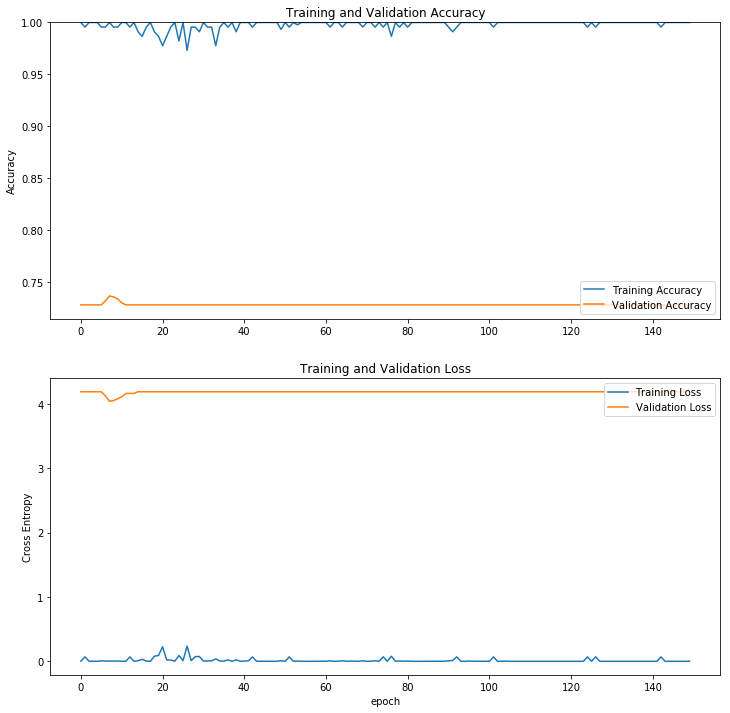

In [9]:
flatten = lambda l: [item for sublist in l for item in sublist]
# x = flatten(list(acc_fine))
# xx = flatten(val_acc_fine)
# y = flatten(loss_fine)
# yy = flatten(val_loss_fine)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc_fine, label='Training Accuracy') 
plt.plot(val_acc_fine, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_fine, label='Training Loss')
plt.plot(val_loss_fine, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [10]:
model.evaluate(test_batches, steps = 7)

7/7 [==============================] - 3s 412ms/step - loss: 6.1607 - accuracy: 0.5982


[6.160676343100412, 0.59821427]